In [9]:
import numpy as np
from scipy.integrate import solve_ivp
import matplotlib.pyplot as plt
from tqdm import tqdm
import pandas as pd
import itertools

# Setting up a mapping between each growth medium and its supplied resource composition

The matrix CSM is 75 x 16, for 75 media and 16 resources. Each row describes which resources are supplied in that medium, and at what relative concentration. Concentrations in each row always add up to 1. Here, we are setting everything in the matrix semi-manually, semi-algorithmically, for convenience.

#### Single resource media

In [17]:
CSM = np.zeros((75,16));
for i in np.arange(16):
    CSM[i,i]=1;
    CSM[58+i, i]= -1/15;

#### Two resource media

In [18]:
CSM[16,0]=1/2; CSM[16,-1]=1/2; CSM[17,9]=1/2; CSM[17,4]=1/2; CSM[18,1]=1/2; CSM[18,-6]=1/2; CSM[19,-2]=1/2; CSM[19,-3]=1/2; 
CSM[20,2]=1/2; CSM[20,8]=1/2; CSM[21,5]=1/2; CSM[21,6]=1/2; CSM[22,7]=1/2; CSM[22,-4]=1/2; CSM[23,-5]=1/2; CSM[23,3]=1/2; 
CSM[24,7]=1/2; CSM[24,3]=1/2; CSM[25,6]=1/2; CSM[25,-2]=1/2; CSM[26,0]=1/2; CSM[26,-8]=1/2; CSM[27,-3]=1/2; CSM[27,2]=1/2; 
CSM[28,-4]=1/2; CSM[28,-5]=1/2; CSM[29,-6]=1/2; CSM[29,4]=1/2; CSM[30,5]=1/2; CSM[30,9]=1/2; CSM[31,1]=1/2; CSM[31,-1]=1/2; 
CSM[32,-1]=1/2; CSM[32,4]=1/2; CSM[33,5]=1/2; CSM[33,3]=1/2; CSM[34,2]=1/2; CSM[34,-5]=1/2; CSM[35,-3]=1/2; CSM[35,0]=1/2; 
CSM[36,1]=1/2; CSM[36,9]=1/2; CSM[37,8]=1/2; CSM[37,10]=1/2; CSM[38,6]=1/2; CSM[38,7]=1/2; CSM[39,-2]=1/2; CSM[39,-4]=1/2; 

#### Four-resource media

In [19]:
for i in np.arange(4): # 4 resource combinations
    CSM[40+i,:] = 1/4*( CSM[16+i*2]+CSM[16+i*2+1] > 0 );
    CSM[44+i,:] = 1/4*( CSM[24+i*2]+CSM[24+i*2+1] > 0 );
    CSM[48+i,:] = 1/4*( CSM[32+i*2]+CSM[32+i*2+1] > 0 );

#### Eight-resource media

In [22]:
for i in np.arange(2):
    CSM[52+i] = 1/8*( CSM[40+i*2]+CSM[40+i*2+1] > 0 );
    CSM[54+i] = 1/8*( CSM[44+i*2]+CSM[44+i*2+1] > 0 );
    CSM[56+i] = 1/8*( CSM[48+i*2]+CSM[48+i*2+1] > 0 );

#### Fifteen and sixteen-resource media

In [21]:
CSM[58:-1,:] += 1/15
CSM[-1,:] += 1/16

# Importing the known cross-feeding matrix, derived from metabolic scope expansion.

In the matrix, rows correspond to input metabolites (upstream resources) and the columns correspond to output metabolites (immediate byproducts).

In [23]:
singles = np.array([3,10,14,17,19,21,22,26,28,33,46,49,51,62,63,69]);
singles_names = ['glucose','sucrose','fructose','glycerol','fumarate','citrate','mannose','xylose','cellobiose','maltose','galacturonate','starch','mannitol','cellulose','sorbitol','proline'];

CFm0 = pd.read_csv('data_metabolism/cf_matrix_upper_bound_mergers.csv', names=np.arange(96)); 
CFm0 = np.array(CFm0);

## Setting the TCA cycle intermediates (core metabolites) to always be produced.

Because the TCA intermediates are always downstream of every supplied resource we have, we assume that they can always be produced. In the model, every other metabolic byproduct can only be produced if it is a direct byproduct of a resource consumed by a species.

In [24]:
core_indices = [ 2, 4, 5, 6, 11, 19, 20, 21, 44 ]
for ci, cj in itertools.combinations( core_indices, 2 ):
    CFm0[ ci, cj ] = 1

Ensuring energy conservation. Whenever a resource can produce multiple byproducts, we want the total amount of all byproducts to never exceed the resource itself. Here, we normalize all the byproducts to the upstream resource amount.

In [25]:
CFm1=np.copy(CFm0)
for i in np.arange(np.shape(CFm1)[0]):
    if(np.sum(CFm1[i] > 0)  ):
        CFm1[i] = CFm1[i]/np.sum(CFm1[i])

Defining the resource supply vector for each growth medium, so that it is normalized, and adding a small amount of acetate to kickstart TCA reactions. (This needs to be done because for some resources, the TCA cycle could be far from them, but we assume that TCA intermediates would nevertheless be present.)

In [27]:
CFm=CFm1;
a = np.zeros((16,np.shape(CFm)[0]));
for i in np.arange(16):
    a[i,singles[i]]=1;

a[:, 4]+=0.2
CJ0s = CSM@a;

# Resource dynamics

This function calculates the change in resource concentrations and species abundances for one time step, according to the consumer-resource dynamical equations in the model.

In [28]:
def CFlog( t, nc, rij, cf, l, cj0, d, scale=1):
    '''
    PARAMETERS:
        nc : population + concentration abundances, 
        rij : growth rate, 
        cf : consumption + cross-feeding coefficients, 
        l : leakage rate, 
        cj0 : supply rate, 
        d : dilution rate, 
        scale : sets the scale between concentration and population (like a resource to biomass yield)
    '''
    S = len(nc) - len(cj0);
    n = nc[:S]; c=nc[S:]; c=c*(c>0);
    dn = (1-l)*np.sum(rij*c, axis=1)-d; 
    consume = c*np.sum(rij.T*np.exp(n), axis=1); 
    dc = - scale*np.matmul( consume, cf ).reshape(len(cj0)) + d *(cj0 - c);
    
    return np.concatenate([dn,dc]);

This function runs one set of dynamical simulations for 1000 time units, over all 75 media, using the function for one time step we defined above. 

In [35]:
def CFrun_real( S=96, R=96, D=0.1, l=0.01, c=1, cfm=CFm,  Cj0s=CJ0s, scale=1):
    '''
    PARAMETERS:
       D : dilution rate, 
       l : leakage, 
       c : scale of supply concentration, 
       cfm : the cross-feeding matrix, 
       Cj0s : supplied resource concentrations
    '''
    nss = np.zeros((Cj0s.shape[0],S+R))-8; 
    
    # Construct growth rates
    Rij = np.diag(np.random.normal(1,0.01, size=S)  ); # 'specialist' pool
    cf = np.diag(np.ones(R)); cf=cf-l*cfm; # cf consists of consumption + cross-feeding
    
    # Going over all media.
    for i in tqdm(np.arange( Cj0s.shape[0] )):
        def CF_wrap(t,nc):
            return CFlog(t, nc, rij=Rij, cf=cf, l=l, cj0=c*Cj0s[i], d=D, scale=scale  )
        
        # Solving for one medium.
        sol= solve_ivp( CF_wrap, ( 0, 1000 ), y0=np.concatenate( [np.ones(S)*(-7), c*Cj0s[i]] ), method='Radau');
        nss[i,:] = sol.y[:,-1];
    return nss, sol

# Building the plotting suit. Setting colors, parameters, and plot styles.

This is just to set up the plot that follows, so this can be ignored.

In [7]:
###########################################
# code for plotting the result
def plot_real(nss, csm=CSM, th=0):
# th is an arbitrary threshold for counting the number of metabolites
    fig, ax = plt.subplots(2,2, figsize=(10,12), facecolor='white');
    S = np.shape(nss)[-1]//2;
    surv = 1*((nss[:,:S])>-7);
    media = 1*(nss[:,S:]>th);
    # define specialists and generalists
    spstat = np.sum(surv[:16], axis=0);
    restat = np.sum(media[:16], axis=0);
    richness = np.sum(surv, axis=1);
    nmet = np.sum(media, axis=1);
    special = np.where( (spstat>0)*(spstat<4) )[0]; nspe = np.sum(surv[:16,special], axis=1);
    inter = np.where( (spstat>3)*(spstat<14) )[0]; nint = np.sum(surv[:16,inter], axis=1);
    general = np.where( (spstat>13) )[0]; ngen = np.sum(surv[:16,general], axis=1);
    peri = np.where( (restat>0)*(restat<4) )[0]; nperi = np.sum(media[:16,peri], axis=1);
    interm = np.where( (restat>3)*(restat<14) )[0]; nintm = np.sum(media[:16,interm], axis=1);
    core = np.where( (restat>13) )[0]; ncore = np.sum(media[:16,core], axis=1);
    
    ax[0,0].bar(singles_names,ngen, color='#f5a28f')
    ax[0,0].bar(singles_names,nint, bottom=ngen, color='#e5dec2')
    ax[0,0].bar(singles_names,nspe, bottom=ngen+nint, color='#87babb')
    
    ax[0,1].bar(singles_names,ncore, color='#f5a28f')
    ax[0,1].bar(singles_names,nintm, bottom=ncore, color='#e5dec2')
    ax[0,1].bar(singles_names,nperi, bottom=ncore+nintm, color='#87babb')
    
    ax[0,0].set_xticklabels(labels=singles_names, rotation=90)
    ax[0,1].set_xticklabels(labels=singles_names, rotation=90)
    
    nrs = np.zeros((6,2,2));
    for i in np.arange(6):
        nr = [1,2,4,8,15,16][i]; 
        target = np.where(np.sum(csm>0, axis=1)==nr)[0]; survt = surv[target]; mediat=media[target];
        ax[1,0].bar( nr, np.sum(survt[:,general])/len(target), color='#f5a28f' );
        ax[1,0].bar( nr, np.sum(survt[:,inter])/len(target), bottom=np.sum(survt[:,general])/len(target), color='#e5dec2' );
        ax[1,0].bar( nr, np.sum(survt[:,special])/len(target), bottom=np.sum(survt[:,general])/len(target)+np.sum(survt[:,inter])/len(target), color='#87babb' );
        ax[1,1].bar( nr, np.sum(mediat[:,core])/len(target), color='#f5a28f' );
        ax[1,1].bar( nr, np.sum(mediat[:,interm])/len(target), bottom=np.sum(mediat[:,core])/len(target), color='#e5dec2' );
        ax[1,1].bar( nr, np.sum(mediat[:,peri])/len(target), bottom=np.sum(mediat[:,core])/len(target)+np.sum(mediat[:,interm])/len(target), color='#87babb' );
        nrs[i,0,0] = np.average(richness[target], axis=0);
        nrs[i,0,1] = np.std(richness[target], axis=0)/np.sqrt(len(target));
        nrs[i,1,0] = np.average(nmet[target], axis=0);
        nrs[i,1,1] = np.std(nmet[target], axis=0)/np.sqrt(len(target));
    ax[1,0].errorbar([1,2,4,8,15,16], nrs[:,0,0], yerr=nrs[:,0,1], color='k' );
    ax[1,1].errorbar([1,2,4,8,15,16], nrs[:,1,0], yerr=nrs[:,1,1], color='k' );
    ax[1,0].set_xlabel('Number of CS');
    ax[1,0].set_ylabel('Richness');
    ax[0,0].set_ylabel('Richness');
    ax[1,1].set_xlabel('Number of CS');
    ax[1,1].set_ylabel('Number of metabolites');
    ax[0,1].set_ylabel('Number of metabolites');
    plt.savefig('trend.pdf')
    return fig, ax, nrs

# Final piece: running one set of dynamics for a given set of parameters, and plotting the results.

## Run

In [36]:
nss, sol = CFrun_real(l=0.1, D=0.1, c=100, Cj0s=CJ0s, scale=1);

100%|██████████████████████████████████████████████████████████████████████████████████| 75/75 [00:59<00:00,  1.27it/s]


## Plot results

<ipython-input-7-312abc504458>:29: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax[0,0].set_xticklabels(labels=singles_names, rotation=90)
<ipython-input-7-312abc504458>:30: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax[0,1].set_xticklabels(labels=singles_names, rotation=90)


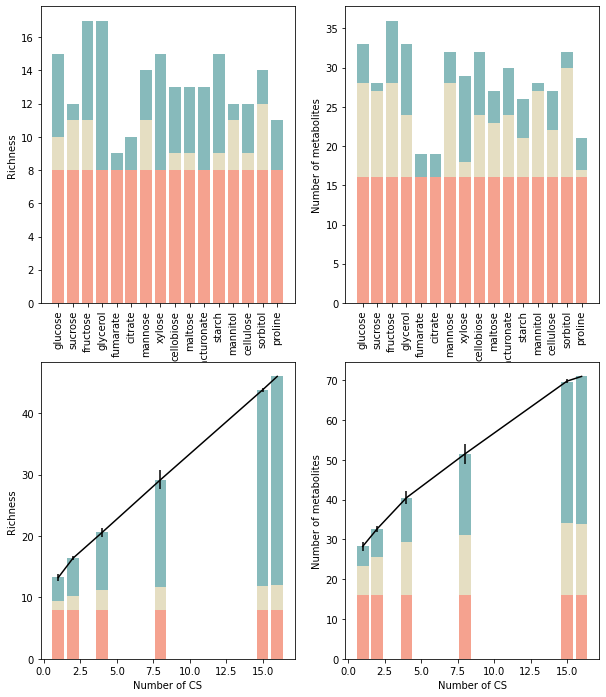

In [37]:
fig, ax, nrs = plot_real(nss, th=0.)